In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import importlib
import warnings

warnings.filterwarnings('ignore')
from tensorflow.keras.models import load_model

import Model
importlib.reload(Model)


def visualize_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Loss (Train & Validation)
    axs[0].plot(history.history['loss'], label='Train Loss', marker='o', markersize=4)
    axs[0].plot(history.history['val_loss'], label='Val Loss', marker='*', markersize=4)
    axs[0].set_title('Model Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Accuracy (Train & Validation)
    axs[1].plot(history.history['accuracy'], label='Train Accuracy', marker='o', markersize=4)
    axs[1].plot(history.history['val_accuracy'], label='Val Accuracy', marker='*', markersize=4)
    axs[1].set_title('Model Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


def get_dataset(path, classes, show_labels):
    for c_idx, c in enumerate(classes):
        raw_data = os.listdir(path+c)
        if len(raw_data) == 1:
            mat = scipy.io.loadmat(path+c+raw_data[0])
        else:
            print("There is more than one dataset - check")

        if c_idx == 0:
            print(f"Import matlab raw dataset - Matlab file Keys: {mat.keys()}")
            #pass

        if mat['Data_Cls'].shape[-1] != mat['Data_Fea'].shape[-1]:
            print(f"Label and dataset do not match! : {len(mat['Data_Cls'])}, {len(mat['Data_Fea'])}")
            break

        if c_idx == 0:
            feature_set = np.transpose(mat['Data_Fea'], (2, 0, 1))  # shape: (1729, 4, 14)
            labels = mat['Data_Cls'].flatten()  #0 or class (either one)

        elif c_idx > 0:
            feature_set_added = np.transpose(mat['Data_Fea'], (2, 0, 1))
            labels_addend = mat['Data_Cls'].flatten()  #0 or class (either one)

            feature_set = np.concatenate([feature_set, feature_set_added], axis=0)
            labels = np.concatenate([labels, labels_addend], axis=0)
        else:
            print("Error in c_idx")
            break

    if show_labels:
        plt.figure(figsize=(8,3))
        plt.plot(labels)
        plt.ylabel('Class label', fontsize=13)
        plt.xlabel('Samples', fontsize=13)
        plt.grid(True, which='both', linestyle='--')
        plt.show()

    return feature_set, labels


def split_data(X, Y, ratio):
    #Splits (N, C, F) data and 1D labels into training and validation sets.

    num_samples = X.shape[0]
    indices = np.random.permutation(num_samples)

    training_size = int(round(num_samples * ratio))
    training_indices = indices[:training_size]
    validation_indices = indices[training_size:]

    training_data = X[training_indices]
    training_labels = Y[training_indices]
    validation_data = X[validation_indices]
    validation_labels = Y[validation_indices]

    training_data = np.expand_dims(training_data, axis=-1)  # Adds a new channel dimension at the end
    validation_data = np.expand_dims(validation_data, axis=-1)

    return training_data, training_labels, validation_data, validation_labels



def adaptation_transfer_learning_with_small_samples(path, classes, session_info, best_model, set_epoch, set_batch_size,
                                                    train_ratio, set_verbose, save_model_set, show_class_distribution):

    feature_set, labels = get_dataset(path, classes, show_labels=show_class_distribution)
    X_train, y_train, X_test, y_test = split_data(feature_set, labels, train_ratio)
    print(f"Shapes  =>  X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")


    init_test_loss, init_test_acc = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"\n Unseen session performance ===================> date {session_info}\n"
          f"Loss: {np.round(init_test_loss, 4)}, Acc: {np.round(init_test_acc, 4)*100}%")

    print(f"\n After adaptation (Transfer learning with small samples) - date {session_info}")

    history, get_model = Model.Train_model(best_model, X_train, y_train, X_test, y_test,
                                set_epoch, set_batch_size, version, set_verbose, save_model_set)
    visualize_history(history)

    #test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
    maximum_test_acc = np.max(history.history['val_accuracy'])

    difference = np.round((maximum_test_acc - init_test_acc)*100, 2)
    print(f"Accuracy Difference (Initial accuracy before training - max test accuracy after training): {difference}%")

    if difference > 0:
        print(f"\t ===>  Positive - (Indicates that the performance have improved)")
    elif difference < 0:
        print(f"\t ===>  Negative - (Indicates that the performance have decreased)")

    return float(maximum_test_acc), init_test_acc, get_model

In [2]:
default_path = "C:/Users/hml76/OneDrive/문서/MATLAB/data/"
classes = ['1/','2/','3/','4/','5/']
version = 'V1'

#Info = ['05_27_stand', '06_18_stand', '06_20_stand', '06_20_sit_chair', '06_20_sit_chair_leg_crossed', '06_20_sit_floor']
Info = ['05_27_stand', '06_18_stand', '06_20_stand', '06_20_sit_chair', '06_20_sit_chair_leg_crossed', '06_20_sit_floor']

Import matlab raw dataset - Matlab file Keys: dict_keys(['__header__', '__version__', '__globals__', 'Data_ADC', 'Data_Cls', 'Data_Fea', 'Dev_Channels', 'Dev_Info', 'Dev_NCh'])


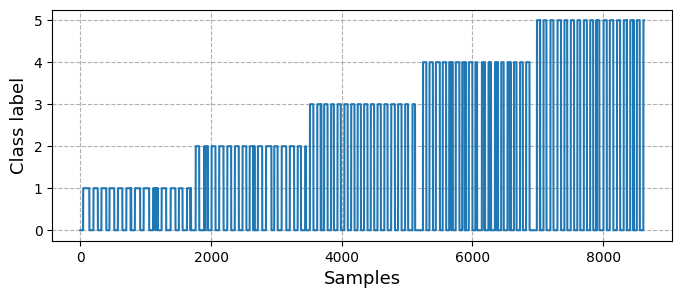

Shapes : (6900, 4, 14, 1) (6900,) (1725, 4, 14, 1) (1725,)


In [3]:
path = default_path + 'Exp_2025-05-27/E8331D05289A/raw/'

feature_set, labels = get_dataset(path, classes, show_labels=True)
X_train, y_train, X_test, y_test = split_data(feature_set, labels, ratio=0.8)
print("Shapes :", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [ ]:
model = Model.Original_model_V1(X_train.shape[1:])
set_epoch, set_batch_size = 50, 256

history = Model.Train_model(model, X_train, y_train, X_test, y_test, set_epoch, set_batch_size, version,
                            set_verbose=0,
                            save_model_set=True)
visualize_history(history)

# model.evaluate(X_test, y_test) # See if it matches with the best validation acc

In [ ]:
try:
    del X_train, X_test, model, y_train, y_test, history, feature_set, labels
except:
    pass

In [3]:
importlib.reload(Model)
best_model = load_model(f'best_model_{version}.keras')

In [4]:
Trained_acc_all, Init_acc_all = [], []

# New session

Import matlab raw dataset - Matlab file Keys: dict_keys(['__header__', '__version__', '__globals__', 'Data_ADC', 'Data_Cls', 'Data_Fea', 'Dev_Channels', 'Dev_Info', 'Dev_NCh'])
Shapes  =>  X_train: (2155, 4, 14, 1), y_train: (2155,), X_test: (6466, 4, 14, 1), y_test: (6466,)

 Unseen session performance ===================> date Exp_2025-06-18
Loss: 0.4731, Acc: 85.04%

 After adaptation (Transfer learning with small samples) - date Exp_2025-06-18
Start Training ... total epochs: 50
Finish Training! (Model is NOT saved)

Maximum training accuracy : 82.09%
Maximum validation accuracy : 85.18%


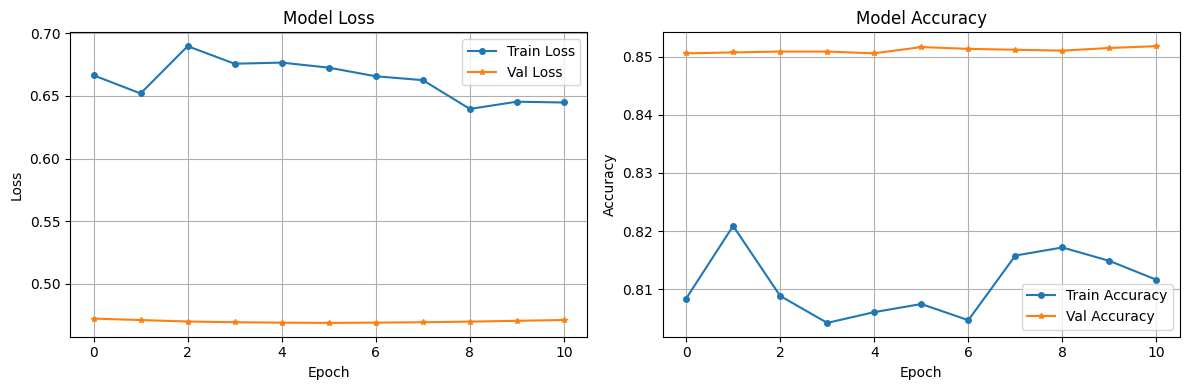

Accuracy Difference (Initial accuracy before training - max test accuracy after training): 0.14%
	 ===>  Positive - (Indicates that the performance have improved)


In [5]:
session_info = "Exp_2025-06-18"
path = default_path + f'{session_info}/E9AD0E7DCC2B/raw/'
set_epoch, set_batch_size = 50, 256 #Default to the matlab

trained_test_acc, untrained_test_acc, new_Best_model = adaptation_transfer_learning_with_small_samples(path, classes, session_info,
                                                                                       best_model, set_epoch, set_batch_size,
                                                                                        train_ratio=0.25,
                                                                                        set_verbose=False,
                                                                                        save_model_set=False,
                                                                                        show_class_distribution=False)
Trained_acc_all.append(trained_test_acc)
Init_acc_all.append(untrained_test_acc)

In [6]:
try:
    del best_model
except:
    pass

importlib.reload(Model)
best_model = load_model(f'best_model_{version}.keras')

# New session

Import matlab raw dataset - Matlab file Keys: dict_keys(['__header__', '__version__', '__globals__', 'Data_ADC', 'Data_Cls', 'Data_Fea', 'Dev_Channels', 'Dev_Info', 'Dev_NCh'])
Shapes  =>  X_train: (2147, 4, 14, 1), y_train: (2147,), X_test: (6441, 4, 14, 1), y_test: (6441,)

 Unseen session performance ===================> date Exp_2025-06-20-v1
Loss: 0.4416, Acc: 82.80999999999999%

 After adaptation (Transfer learning with small samples) - date Exp_2025-06-20-v1
Start Training ... total epochs: 50
Finish Training! (Model is NOT saved)

Maximum training accuracy : 79.04%
Maximum validation accuracy : 83.23%


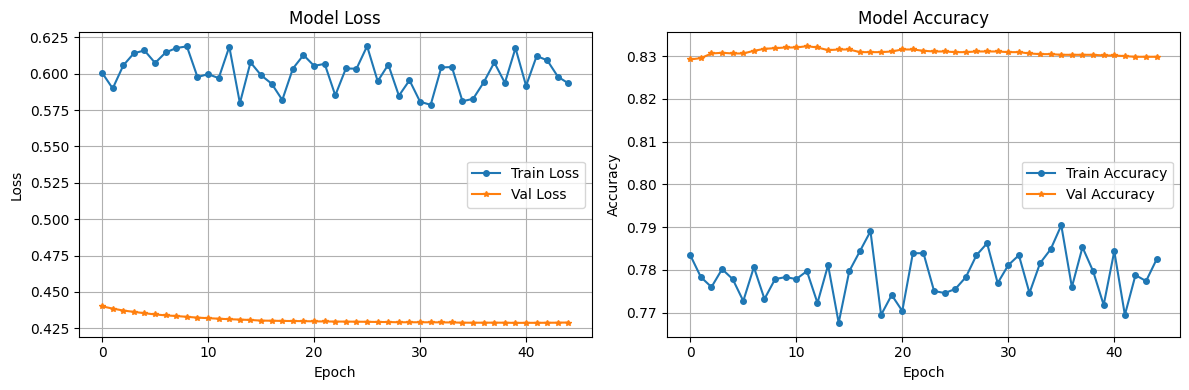

Accuracy Difference (Initial accuracy before training - max test accuracy after training): 0.42%
	 ===>  Positive - (Indicates that the performance have improved)


In [7]:
session_info = "Exp_2025-06-20-v1"
path = default_path + f'{session_info}/E9AD0E7DCC2B/raw/'

set_epoch, set_batch_size = 50, 256 #Default to the matlab

trained_test_acc, untrained_test_acc, new_Best_model = adaptation_transfer_learning_with_small_samples(path, classes, session_info,
                                                                                       new_Best_model, set_epoch, set_batch_size,
                                                                                        train_ratio=0.25,
                                                                                        set_verbose=False,
                                                                                        save_model_set=False,
                                                                                        show_class_distribution=False)
Trained_acc_all.append(trained_test_acc)
Init_acc_all.append(untrained_test_acc)

In [8]:
try:
    del best_model
except:
    pass

importlib.reload(Model)
best_model = load_model(f'best_model_{version}.keras')

Import matlab raw dataset - Matlab file Keys: dict_keys(['__header__', '__version__', '__globals__', 'Data_ADC', 'Data_Cls', 'Data_Fea', 'Dev_Channels', 'Dev_Info', 'Dev_NCh'])
Shapes  =>  X_train: (2153, 4, 14, 1), y_train: (2153,), X_test: (6460, 4, 14, 1), y_test: (6460,)

 Unseen session performance ===================> date Exp_2025-06-20-v2
Loss: 0.3561, Acc: 87.92999999999999%

 After adaptation (Transfer learning with small samples) - date Exp_2025-06-20-v2
Start Training ... total epochs: 50
Finish Training! (Model is NOT saved)

Maximum training accuracy : 83.14%
Maximum validation accuracy : 87.91%


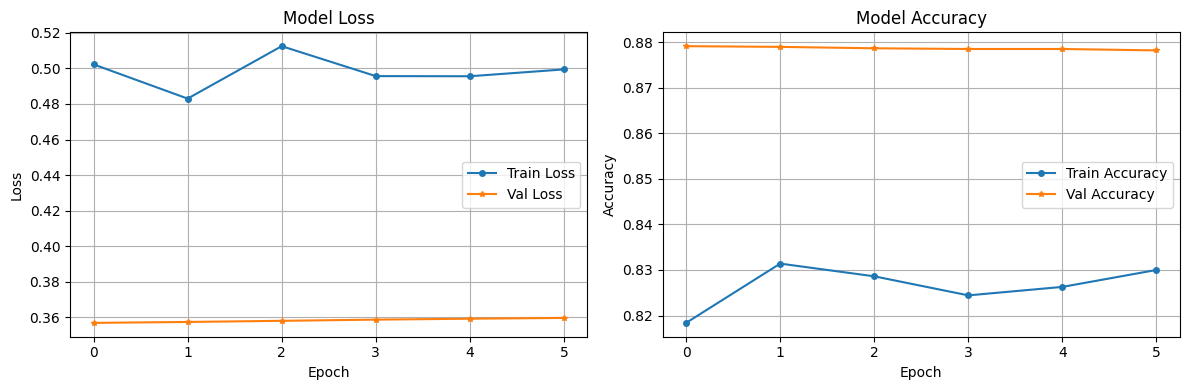

Accuracy Difference (Initial accuracy before training - max test accuracy after training): -0.02%
	 ===>  Negative - (Indicates that the performance have decreased)


In [9]:
session_info = "Exp_2025-06-20-v2"
path = default_path + f'{session_info}/E9AD0E7DCC2B/raw/'

set_epoch, set_batch_size = 50, 256 #Default to the matlab

trained_test_acc, untrained_test_acc, new_Best_model = adaptation_transfer_learning_with_small_samples(path, classes, session_info,
                                                                                       new_Best_model, set_epoch, set_batch_size,
                                                                                        train_ratio=0.25,
                                                                                        set_verbose=False,
                                                                                        save_model_set=False,
                                                                                        show_class_distribution=False)
Trained_acc_all.append(trained_test_acc)
Init_acc_all.append(untrained_test_acc)

Import matlab raw dataset - Matlab file Keys: dict_keys(['__header__', '__version__', '__globals__', 'Data_ADC', 'Data_Cls', 'Data_Fea', 'Dev_Channels', 'Dev_Info', 'Dev_NCh'])
Shapes  =>  X_train: (1922, 4, 14, 1), y_train: (1922,), X_test: (5765, 4, 14, 1), y_test: (5765,)

 Unseen session performance ===================> date Exp_2025-06-20-v3
Loss: 0.3886, Acc: 89.73%

 After adaptation (Transfer learning with small samples) - date Exp_2025-06-20-v3
Start Training ... total epochs: 50
Finish Training! (Model is NOT saved)

Maximum training accuracy : 83.25%
Maximum validation accuracy : 89.66%


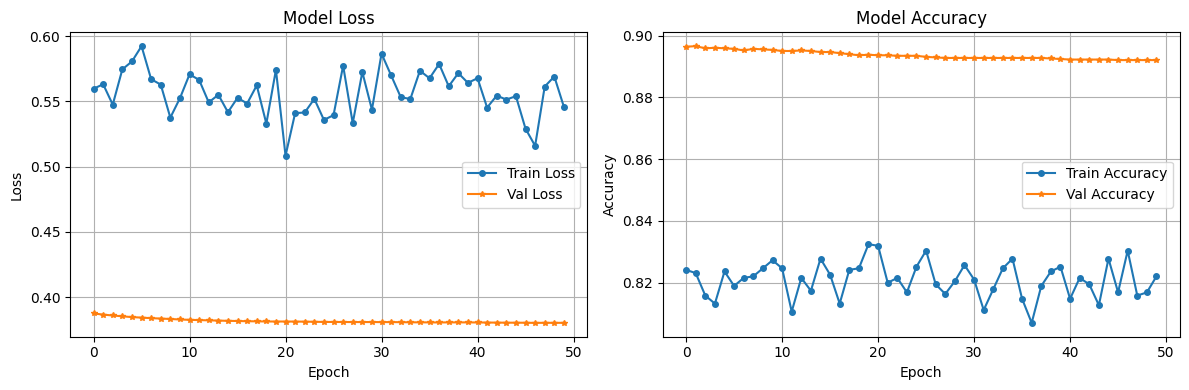

Accuracy Difference (Initial accuracy before training - max test accuracy after training): -0.07%
	 ===>  Negative - (Indicates that the performance have decreased)


In [11]:
session_info = "Exp_2025-06-20-v3"
path = default_path + f'{session_info}/E9AD0E7DCC2B/raw/'

set_epoch, set_batch_size = 50, 256 #Default to the matlab

trained_test_acc, untrained_test_acc, new_Best_model = adaptation_transfer_learning_with_small_samples(path, classes, session_info,
                                                                                       new_Best_model, set_epoch, set_batch_size,
                                                                                        train_ratio=0.25,
                                                                                        set_verbose=False,
                                                                                        save_model_set=False,
                                                                                        show_class_distribution=False)
Trained_acc_all.append(trained_test_acc)
Init_acc_all.append(untrained_test_acc)

Import matlab raw dataset - Matlab file Keys: dict_keys(['__header__', '__version__', '__globals__', 'Data_ADC', 'Data_Cls', 'Data_Fea', 'Dev_Channels', 'Dev_Info', 'Dev_NCh'])
Shapes  =>  X_train: (2158, 4, 14, 1), y_train: (2158,), X_test: (6473, 4, 14, 1), y_test: (6473,)

 Unseen session performance ===================> date Exp_2025-06-20-v4
Loss: 1.4023, Acc: 71.17%

 After adaptation (Transfer learning with small samples) - date Exp_2025-06-20-v4
Start Training ... total epochs: 50
Finish Training! (Model is NOT saved)

Maximum training accuracy : 69.32%
Maximum validation accuracy : 71.56%


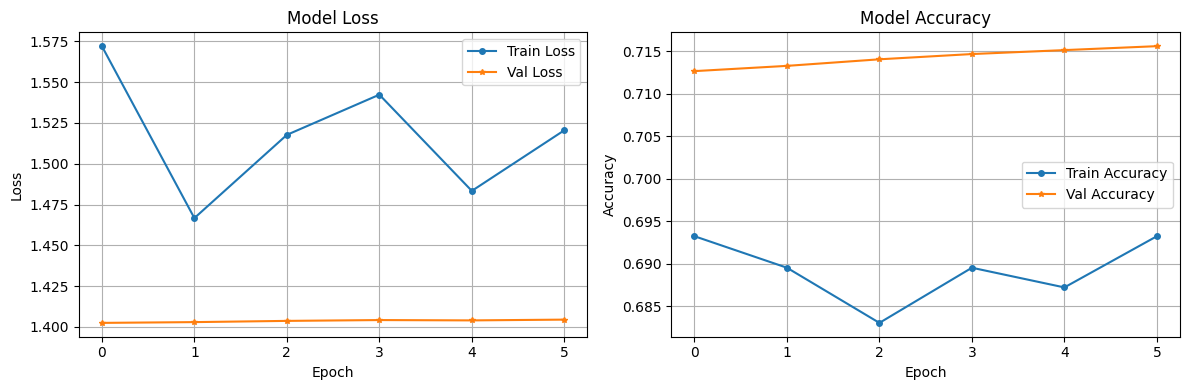

Accuracy Difference (Initial accuracy before training - max test accuracy after training): 0.39%
	 ===>  Positive - (Indicates that the performance have improved)


In [12]:
session_info = "Exp_2025-06-20-v4"
path = default_path + f'{session_info}/E9AD0E7DCC2B/raw/'

set_epoch, set_batch_size = 50, 256 #Default to the matlab

trained_test_acc, untrained_test_acc, new_Best_model = adaptation_transfer_learning_with_small_samples(path, classes, session_info,
                                                                                       new_Best_model, set_epoch, set_batch_size,
                                                                                        train_ratio=0.25,
                                                                                        set_verbose=False,
                                                                                        save_model_set=False,
                                                                                        show_class_distribution=False)
Trained_acc_all.append(trained_test_acc)
Init_acc_all.append(untrained_test_acc)

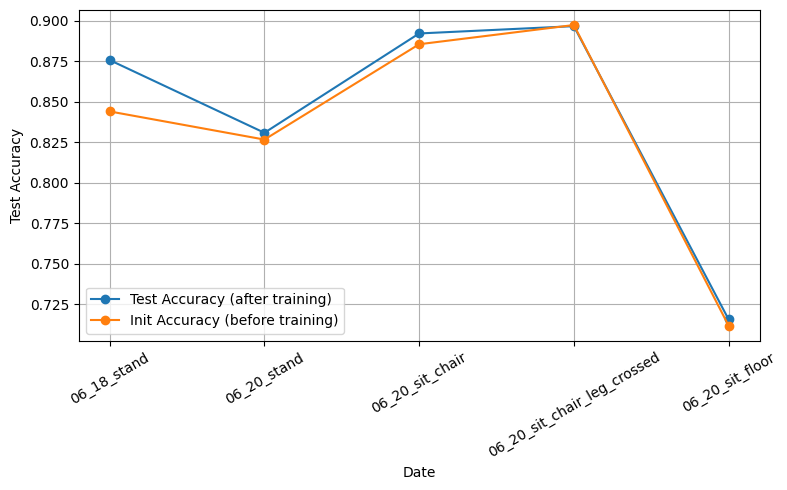

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(Info[1:], Trained_acc_all, marker='o')
plt.plot(Info[1:], Init_acc_all, marker='o')

plt.xlabel('Date')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=30)
plt.legend(['Test Accuracy (after training)', 'Init Accuracy (before training)'])
plt.grid(True)
plt.tight_layout()
plt.show()

1. training them from scratch (Online learning)
2. Transfer learning model
3. Meta Learning

Which is the best???